## Dendrogram flow on KITTI Mask dataset

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ltcl
from ltcl.modules.trainer import Dendrogram
from ltcl.modules.dendrogram import AfflineDendrogramFlow
import torch
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:3" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### KittiMask

In [5]:
from ltcl.datasets.kitti import KittiMasks
import numpy as np
import numpy.random as random_state

In [9]:
dataset = KittiMasks("/home/cmu_wyao/projects/slow_disentanglement/data/kitti/")

dict_keys(['pedestrians', 'pedestrians_latents'])


In [6]:
train_data, val_data = random_split(dataset, [80000, 2506])

In [7]:
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader   = DataLoader(train_data, batch_size=128, shuffle=False)

In [8]:
batch = next(iter(train_loader))

### Warm start

Initialize the transition noise to Laplacian sparse noise

In [9]:
flow = AfflineDendrogramFlow(input_dims = (1, 64, 64),
                             width = 128,
                             depth = 32,
                             n_levels = 3,
                             lags = 1)
flow = flow.to(device)

In [11]:
spline_optimizer = torch.optim.Adam(flow.spline.parameters(), 
                                    lr=1e-3,
                                    weight_decay=0.0)

# Warm-start the prior to standard normal dist
for step in range(5000):
    latent_size = 64*64*1
    y = torch.distributions.laplace.Laplace(0,1).rsample((32, latent_size))
    dataset = y.to(device)
    spline_optimizer.zero_grad()
    z, logabsdet = flow.spline(dataset)
    logp = flow.base_dist.log_prob(z).sum(dim=1) + logabsdet
    loss = -torch.mean(logp)
    loss.backward(retain_graph=True)
    spline_optimizer.step()

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


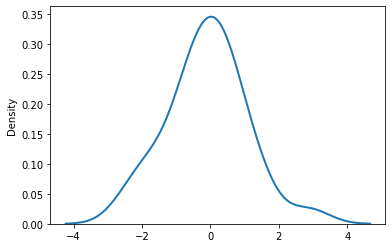

In [12]:
sns.distplot(flow.sample_noise(28).detach().cpu().numpy()[:,150], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label="prior");

In [13]:
torch.save(flow.state_dict(), "/home/cmu_wyao/projects/dendrogram_init.pth")

#### Dendrogram flow

In [8]:
# Callbacks
early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min')

In [8]:
model = Dendrogram(input_dims = (1, 64, 64),
                   width = 64,
                   depth = 16,
                   n_levels = 3,
                   lags = 1,
                   lr = 1e-4) 

In [9]:
model = Dendrogram.load_from_checkpoint("/home/cmu_wyao/checkpoints/dendrogram_0.000000/lightning_logs/version_4/checkpoints/epoch=0-step=4999.ckpt", 
                                        input_dims = (1, 64, 64),
                   width = 128,
                   depth = 32,
                   n_levels = 3,
                   lags = 1,
                   lr = 1e-4)

In [ ]:
trainer = pl.Trainer(default_root_dir = "/home/cmu_wyao/checkpoints/dendrogram",
                     gpus=2, 
                     max_epochs=50,
                     callbacks=[early_stop_callback])

# Train the model
trainer.fit(model, train_loader, val_loader)

/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: You requested multiple GPUs but did not specify a backend, e.g. `Trainer(accelerator="dp"|"ddp"|"ddp2")`. Setting `accelerator="ddp_spawn"` for you.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


/home/cmu_wyao/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


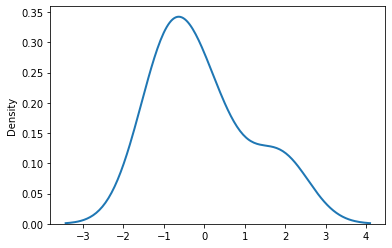

In [42]:
sns.distplot(model.flow.sample_noise(10).detach().cpu().numpy()[:,70], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, label="prior");

In [43]:
model.flow

AfflineDendrogramFlow(
  (unmix): Glow(
    (preprocess): Preprocess()
    (flowlevels): ModuleList(
      (0): FlowLevel(
        (squeeze): Squeeze()
        (flowsteps): FlowSequential(
          (0): FlowStep(
            (0): Actnorm()
            (1): Invertible1x1Conv()
            (2): AffineCoupling(
              (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (actnorm1): Actnorm()
              (conv2): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1), bias=False)
              (actnorm2): Actnorm()
              (conv3): Conv2d(128, 4, kernel_size=(3, 3), stride=(1, 1))
            )
          )
          (1): FlowStep(
            (0): Actnorm()
            (1): Invertible1x1Conv()
            (2): AffineCoupling(
              (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (actnorm1): Actnorm()
              (conv2): Conv2d(128, 128, kernel_size=(1,

In [36]:
first_sample, second_sample, latents1, latents2 = batch
log_probs = model.flow.log_prob(second_sample, first_sample)

In [47]:
es, z, sum_log_abs_det_jacobians = model.flow(second_sample, first_sample)

In [48]:
x,_ = model.flow.inverse(z, first_sample)

In [50]:
x = x.detach().cpu().numpy()

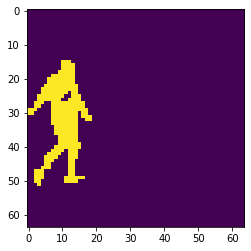

In [31]:
plt.imshow(first_sample[1,0,0])

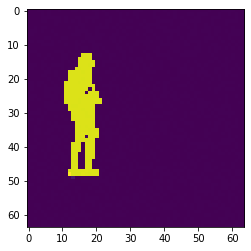

In [51]:
plt.imshow(x[1,0])

In [13]:
import seaborn as sns

<AxesSubplot:>

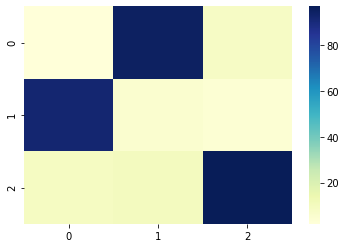

In [16]:
sns.heatmap(C, cmap="YlGnBu")